# Synthetic Bimodal Data Generation - 100x100 Mesh Graph

This notebook generates synthetic bimodal data on a 100x100 regular mesh graph (10K nodes) for testing graph-based interpolation methods.

**Key Features:**
- 100×100 regular mesh grid (10K nodes)
- Bimodal function with two distinct Gaussian peaks and noise
- 4-connected mesh graph with unit edge weights
- Consistent node indexing for graph-based methods
- Random sparse sampling for training data
- Same data structure as wind interpolation example

In [1]:
# =============================================================================
# IMPORTS AND CONFIGURATION
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import time

# Configuration
GRID_SIZE = 100         # 100x100 grid (10K nodes)
NOISE_STD = 0.1         # Standard deviation of noise
TRAINING_RATIO = 0.05   # 5% of nodes for training (500 points)
RANDOM_SEED = 42        # For reproducibility

np.random.seed(RANDOM_SEED)

print(f"Configuration:")
print(f"  Grid size: {GRID_SIZE}×{GRID_SIZE} = {GRID_SIZE**2:,} nodes")
print(f"  Training ratio: {TRAINING_RATIO*100:.1f}%")
print(f"  Expected training points: {int(GRID_SIZE**2 * TRAINING_RATIO):,}")
print(f"  Noise std: {NOISE_STD}")
print(f"  Random seed: {RANDOM_SEED}")

Configuration:
  Grid size: 100×100 = 10,000 nodes
  Training ratio: 5.0%
  Expected training points: 500
  Noise std: 0.1
  Random seed: 42


In [2]:
# =============================================================================
# MESH GRAPH CONSTRUCTION UTILITIES
# =============================================================================

def grid_index(i, j, n_rows, n_cols):
    """Flatten (i,j) -> node id"""
    return i * n_cols + j

def build_mesh_graph(n_rows, n_cols):
    """Build a 4-connected mesh graph efficiently using sparse matrices"""
    n_nodes = n_rows * n_cols
    rows, cols, data = [], [], []
    
    # 4-connected neighbors: right, left, down, up
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    
    for i in range(n_rows):
        for j in range(n_cols):
            node_id = grid_index(i, j, n_rows, n_cols)
            for di, dj in directions:
                ni, nj = i + di, j + dj
                if 0 <= ni < n_rows and 0 <= nj < n_cols:
                    neighbor_id = grid_index(ni, nj, n_rows, n_cols)
                    rows.append(node_id)
                    cols.append(neighbor_id)
                    data.append(1.0)
    
    A = sparse.coo_matrix((data, (rows, cols)), shape=(n_nodes, n_nodes))
    return A.tocsr()

print("Mesh graph utilities defined")

Mesh graph utilities defined


In [3]:
# =============================================================================
# BIMODAL SYNTHETIC DATA GENERATION
# =============================================================================

def generate_bimodal_function(n_rows, n_cols, noise_std=0.1):
    """
    Generate a bimodal function with two distinct Gaussian peaks
    
    Parameters:
    -----------
    n_rows : int
        Number of rows in the grid
    n_cols : int
        Number of columns in the grid  
    noise_std : float
        Standard deviation of additive noise
        
    Returns:
    --------
    y : np.ndarray
        Function values at grid points (flattened)
    coord_mapping : np.ndarray
        (x, y) coordinates for each node
    peak_info : list
        Information about each peak (center, amplitude, width)
    """
    # Create coordinate grids
    x = np.linspace(-2, 2, n_cols)
    y = np.linspace(-2, 2, n_rows)
    X, Y = np.meshgrid(x, y)
    
    # Define two peaks for bimodal distribution
    peak_info = [
        {
            'center': (-1.0, 0.5),
            'amplitude': 2.0,
            'sigma': (0.4, 0.3),
            'rotation': 0.3
        },
        {
            'center': (1.2, -0.7),
            'amplitude': 1.5,
            'sigma': (0.3, 0.5),
            'rotation': -0.5
        }
    ]
    
    # Initialize function as zeros
    f_clean = np.zeros_like(X)
    
    # Generate the two peaks
    for peak in peak_info:
        center_x, center_y = peak['center']
        amplitude = peak['amplitude']
        sigma_x, sigma_y = peak['sigma']
        theta = peak['rotation']
        
        # Generate rotated Gaussian
        a = np.cos(theta)**2 / (2*sigma_x**2) + np.sin(theta)**2 / (2*sigma_y**2)
        b = -np.sin(2*theta) / (4*sigma_x**2) + np.sin(2*theta) / (4*sigma_y**2)
        c = np.sin(theta)**2 / (2*sigma_x**2) + np.cos(theta)**2 / (2*sigma_y**2)
        
        dx = X - center_x
        dy = Y - center_y
        
        gaussian = amplitude * np.exp(-(a*dx**2 + 2*b*dx*dy + c*dy**2))
        f_clean += gaussian
    
    # Add noise
    noise = np.random.normal(0, noise_std, f_clean.shape)
    f_noisy = f_clean + noise
    
    # Flatten to match node indexing
    y_values = f_noisy.flatten()
    
    # Create coordinate mapping
    coord_mapping = np.zeros((n_rows * n_cols, 2))
    for i in range(n_rows):
        for j in range(n_cols):
            node_id = grid_index(i, j, n_rows, n_cols)
            coord_mapping[node_id, 0] = X[i, j]
            coord_mapping[node_id, 1] = Y[i, j]
    
    return y_values, coord_mapping, peak_info

print("Bimodal data generation function defined")

Bimodal data generation function defined


Building mesh graph and generating bimodal synthetic data...
Graph construction completed in 0.04 seconds

✅ Bimodal dataset saved to 'synthetic_bimodal_100x100.npz'
✅ Grid: 100×100, Training: 500


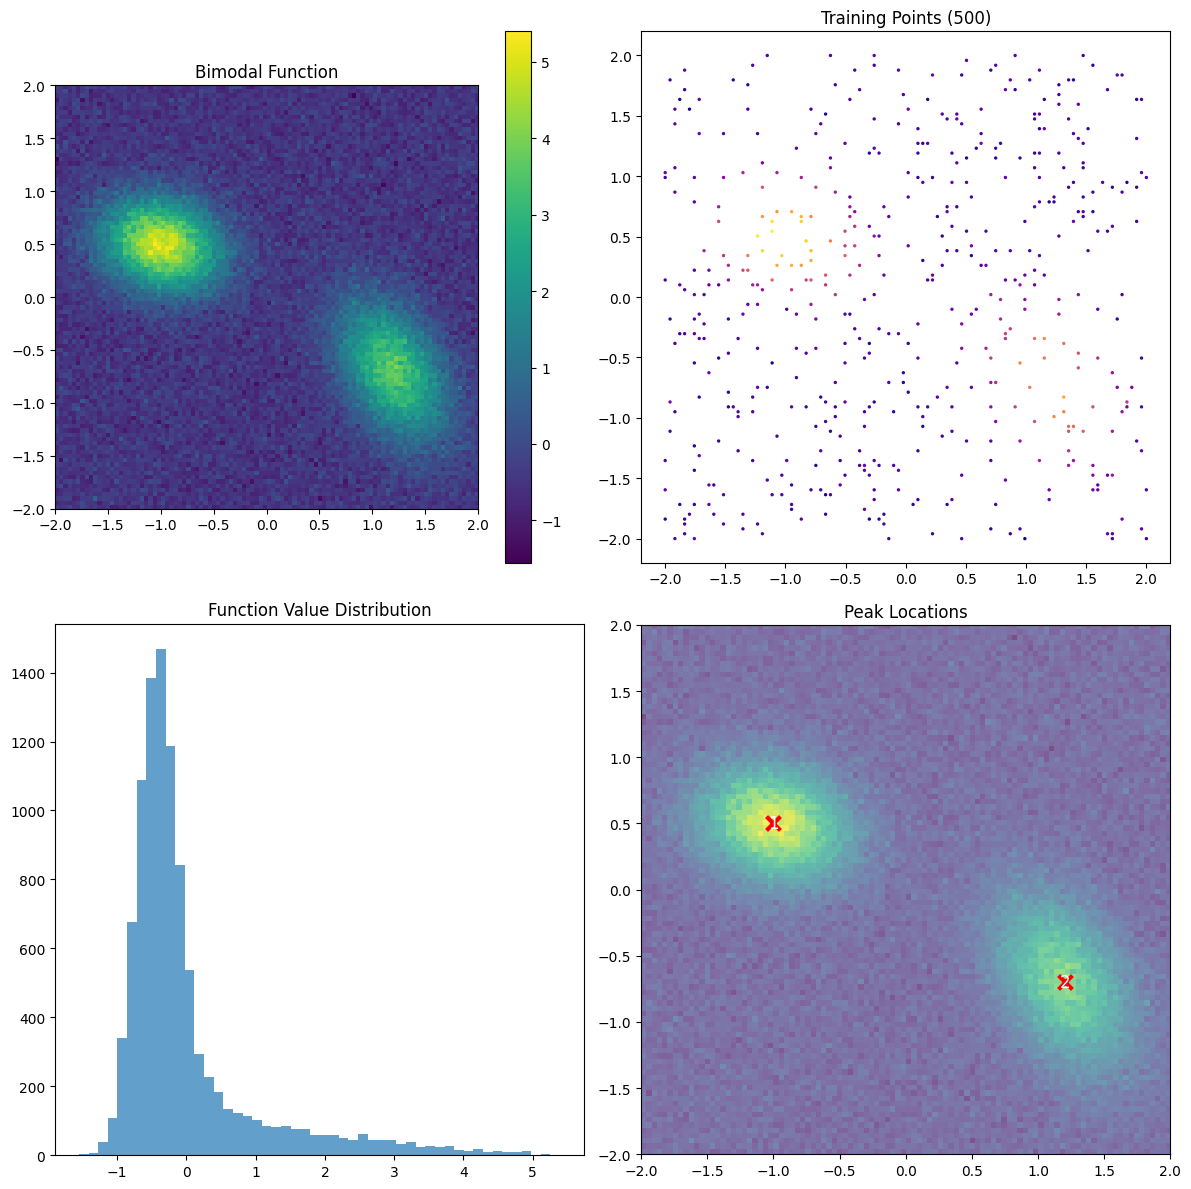

Peak information:
  Peak 1: center=(-1.00, 0.50), amp=2.00
  Peak 2: center=(1.20, -0.70), amp=1.50


In [4]:
# =============================================================================
# BUILD GRAPH AND GENERATE DATA
# =============================================================================

print("Building mesh graph and generating bimodal synthetic data...")
start_time = time.time()

# Build mesh graph
A = build_mesh_graph(GRID_SIZE, GRID_SIZE)
print(f"Graph construction completed in {time.time() - start_time:.2f} seconds")

# Generate bimodal synthetic data
data_start = time.time()
y, coord_mapping, peak_info = generate_bimodal_function(GRID_SIZE, GRID_SIZE, NOISE_STD)

# Normalize data
y_mean, y_std = np.mean(y), np.std(y)
y_normalized = (y - y_mean) / y_std

# Generate training data
n_nodes = GRID_SIZE * GRID_SIZE
X = np.arange(n_nodes)
n_training = int(n_nodes * TRAINING_RATIO)
X_train = np.sort(np.random.choice(n_nodes, size=n_training, replace=False))
y_train = y_normalized[X_train]

# Save dataset
np.savez(f'synthetic_bimodal_{GRID_SIZE}x{GRID_SIZE}.npz',
         A_data=A.data, A_indices=A.indices, A_indptr=A.indptr, A_shape=A.shape,
         X=X, y=y_normalized, y_mean=y_mean, y_std=y_std,
         X_train=X_train, y_train=y_train, coord_mapping=coord_mapping,
         peak_info=peak_info, grid_size=GRID_SIZE, 
         noise_std=NOISE_STD, training_ratio=TRAINING_RATIO, random_seed=RANDOM_SEED)

print(f"\n✅ Bimodal dataset saved to 'synthetic_bimodal_{GRID_SIZE}x{GRID_SIZE}.npz'")
print(f"✅ Grid: {GRID_SIZE}×{GRID_SIZE}, Training: {len(X_train):,}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
y_2d = y_normalized.reshape((GRID_SIZE, GRID_SIZE))

# Full function
im1 = axes[0,0].imshow(y_2d, extent=[-2, 2, -2, 2], cmap='viridis', origin='lower')
axes[0,0].set_title('Bimodal Function')
plt.colorbar(im1, ax=axes[0,0])

# Training points
train_coords = coord_mapping[X_train]
axes[0,1].scatter(train_coords[:, 0], train_coords[:, 1], c=y_train, cmap='plasma', s=2)
axes[0,1].set_title(f'Training Points ({len(X_train):,})')

# Distribution
axes[1,0].hist(y_normalized, bins=50, alpha=0.7)
axes[1,0].set_title('Function Value Distribution')

# Peak locations
axes[1,1].imshow(y_2d, extent=[-2, 2, -2, 2], cmap='viridis', origin='lower', alpha=0.7)
for i, peak in enumerate(peak_info):
    axes[1,1].scatter(peak['center'][0], peak['center'][1], 
                     c='red', s=100, marker='x', linewidth=3)
    axes[1,1].text(peak['center'][0], peak['center'][1], f'{i+1}', 
                  fontsize=12, color='white', ha='center', va='center')
axes[1,1].set_title('Peak Locations')

plt.tight_layout()
plt.show()

print(f"Peak information:")
for i, peak in enumerate(peak_info):
    print(f"  Peak {i+1}: center=({peak['center'][0]:.2f}, {peak['center'][1]:.2f}), amp={peak['amplitude']:.2f}")